# Emojify

- 목표: 단어 백터 사용해서 Emojifier를 구현하자

카톡을 보낼때 내용을 더 표현력있게 전달하고 싶었던 적이 많지 않은가? Emojifier는 이를 돕는 모델이다. 예를 들어, "합격 축하해! 나중에 커피 마시면서 수다떨자~ 사랑해!" 라는 내용을 emojifier는 자동으로 이 문장을 "합격 축하해!👍 나중에 커피 마시면서 수다떨자~☕️ 사랑해!❤️"라고 바꿔준다.

이 프로젝트에서는 문장을 입력했을때 이 문장 내용과 가장 적절한 이모티콘을 자동으로 입력하는 모델을 구현할 것이다. 단어 벡터를 사용한다면 train set에서 특정 이모티콘과 몇 안되는 단어들만 연관시켜도 알고리즘이 이를 일반화시키기 때문에 test set에서 새 단어가 나와도 이를 이모티콘과 연관시킬 수 있다. 이는 적은 양의 train set으로도 꽤 정확한 classifier mapping을 할 수 있게 한다.

가장 먼저 baseline 모델을 만들어 word embedding을 하고, 그 다음 LSTM을 이용해 더 정교한 모델을 만들자.

In [1]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt

%matplotlib inline

## 1 - Baseline model: Emojifier-V1

### 1.1 - Dataset EMOJISET

가장 간단한 baseline 분류기(Emojifier-V1)를 만들어보자.

데이터 구조:
- X: 127개의 문장이 담김
- Y: 0~4의 정수, 각 문장에 해당하는 이모티콘을 레이블링함

<img src="data_set.png" style="width:700px;height:300px;">
<caption><center> **Figure 1**: EMOJISET - 5개의 이모티콘으로 분류하는 문제라 할 수 있다. </center></caption>

### Load Dataset

In [11]:
def read_csv(filename = 'data/emojify_data.csv'):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

In [2]:
# train: 127개의 샘플
X_train, Y_train = read_csv('data/train_emoji.csv')

# test: 56개의 샘플
X_test, Y_test = read_csv('data/tesss.csv')

In [4]:
maxLen = len(max(X_train, key=len).split())
print(maxLen)

10

In [24]:
index = 7
print(X_train[index], label_to_emoji(Y_train[index]))

congratulations on your acceptance 😄


### 1.2 - Overview of the Emojifier-V1

Baseline 모델 "Emojifier-v1"을 만들자. 작동 원리는 아래와 같다.

<center>
<img src="image_1.png" style="width:900px;height:300px;">
<caption><center> **Figure 2**: Baseline 모델 (Emojifier-V1).</center></caption>
</center>

모델의 input은 문장 안의 각 단어들이다. output은 (1,5)형태의 확률벡터로, argmax layer를 통과시켜 가장 적절한 이모티콘의 인덱스를 출력하게 한다.

레이블을 softmax classifier에 훈련시키기 위해 shape을 바꿔줘야 한다. 즉, 현재 (m,1)인 Y컬럼을 one-hot representation인 (m,5)로 바꿔주자. 각 행은 각 문장에 해당하는 레이블에 대한 one-hot 벡터이다.

In [15]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

Let's see what `convert_to_one_hot()` did. Feel free to change `index` to print out different values. 

In [27]:
index = 7
print("문장", Y_train[index], ": one-hot벡터", Y_oh_train[index], "로 변환됨")

문장 2 : one-hot벡터 [ 0.  0.  1.  0.  0.] 로 변환됨


데이터 전처리 끝! 이제 모델을 구현해보자.

### 1.3 - Implementing Emojifier-V1

첫 단계는 input문장을 word vector representation으로 변환한 후 평균을 내는 것이다. Pretrain된 50-dimension의 GloVe embedding을 사용하자. 

In [28]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

- `word_to_index`: (단어 -> 인덱스)로 딕셔너리 맵핑
(400,001 words, with the valid indices ranging from 0 to 400,000)
- `index_to_word`: (인덱스 -> 단어)로 딕셔너리 맵핑
- `word_to_vec_map`: (단어 -> GloVe벡터)로 딕셔너리 맵핑

In [32]:
word = "cucumber"
index = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


2단계로 `sentence_to_avg()` 구현하기:

1. 모든 문장을 소문자로 만든 후, 각 문장을 단어 단위로 나누어 list로 만들자.
2. 문장의 각 단어들에 해당하는 GloVe representation을 구한 후 이 값들을 평균내자.

In [33]:
def sentence_to_avg(sentence, word_to_vec_map):
    
    words = sentence.lower().split()

    #평균 단어 벡터 초기화하기
    avg = np.zeros((50,))
    
    #단어벡터 평균 구하기
    for w in words:
        avg += word_to_vec_map[w]
    avg = avg / len(words)
    
    return avg

In [34]:
avg = sentence_to_avg("I love you", word_to_vec_map)
print("avg = ", avg)

avg =  [-0.00701397  0.54196333 -0.19225433 -0.52465667  0.77827667 -0.04985667
 -0.31802333  0.1746592  -0.52433     0.47641919 -0.33454333  0.93489
 -0.61863667 -0.164186    1.10000667  0.33991333  0.29203     0.35769333
  0.07931167 -0.724163   -0.42256667  0.87212     0.70861667  0.45412333
  1.2277     -2.0613     -1.31806667  0.23561667  1.2105     -1.26068
  3.33396667  0.74604667 -0.60947     0.23688667 -0.31138667 -0.179042
  0.17087667  0.119286    0.35114667 -0.56632333  0.09226223 -0.03197267
 -0.20612     0.41710333  0.168862    0.18619333  0.08125467 -0.80106333
 -0.20057967  0.78087   ]


### Model

위의 `sentence_to_avg()`사용 후 구한 평균값을 forward propagation 하고 cost를 구하자. 그런 다음 backpropagate해서 softmax의 파라미터를 업데이트하자. 사용할 식은 다음과 같다.

$$ z^{(i)} = W . avg^{(i)} + b$$
$$ a^{(i)} = softmax(z^{(i)})$$
$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Yoh^{(i)}_k * log(a^{(i)}_k)$$


In [35]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [36]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):

    np.random.seed(1)

    m = Y.shape[0]                          # train set 샘플 수
    n_y = 5                                 # 클래스 개수  
    n_h = 50                                # GloVe vectors 크기 
    
    # Xavier initialization으로 파라미터 초기화
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Y 를 n_y개의 클래스를 가진 Y_onehot 으로 변환하기
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations):  
        
        # Loop over the training examples
        for i in range(m):                                

            # i번째 샘플의 단어들에 대한 word 벡터들의 평균 구하기
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # 평균 Forward propagate 하기
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Cost 구하기
            cost = -np.sum(Y_oh[i] * np.log(a))

            # gradients 구하기
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # SGD로 파라미터 Update 
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

이제 모델을 학습시켜 softmax 파라미터 W,b를 구하자.


In [37]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.95204988128
Accuracy: 0.348484848485
Epoch: 100 --- cost = 0.0797181872601
Accuracy: 0.931818181818
Epoch: 200 --- cost = 0.0445636924368
Accuracy: 0.954545454545
Epoch: 300 --- cost = 0.0343226737879
Accuracy: 0.969696969697
[[ 3.]
 [ 2.]
 [ 3.]
 [ 0.]
 [ 4.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 3.]
 [ 1.]
 [ 3.]
 [ 3.]
 [ 1.]
 [ 3.]
 [ 2.]
 [ 3.]
 [ 2.]
 [ 3.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 4.]
 [ 3.]
 [ 3.]
 [ 4.]
 [ 0.]
 [ 3.]
 [ 4.]
 [ 2.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 3.]
 [ 4.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 3.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 4.]
 [ 3.]
 [ 0.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 4.]
 [ 2.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 3.]
 [ 4.]
 [ 4.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 3.]
 [ 3.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 2.]
 [ 4.]
 [ 3.]
 [ 3.]
 [ 2.]
 [ 4.]
 [ 0.]
 [ 0.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 2.]
 [ 0.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 

모델이 train set에서 꽤 높은 정확도를 보인다! 이제 test set에 적용해보자.

### 1.4 - test set performance 


In [38]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.977272727273
Test set:
Accuracy: 0.857142857143


만약 랜덤 추측을 했다면 총 5개의 클래스이기 때문에 20%의 정확도를 보였을 것이다. 이에 비해 위의 정확도는 매우 높다고 할 수 있다. 또한, 127개 밖에 안되는 샘플로 좋은 성능을 갖춘 것을 볼 수 있다. 이유는 아래 예시에서 볼 수 있다.

In [ ]:
def print_predictions(X, pred):
    print()
    for i in range(X.shape[0]):
        print(X[i], label_to_emoji(int(pred[i])))

In [45]:
X_my_sentences = np.array(["i adore you", "i love you" ,"funny lol", 'lets play a ball', "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.833333333333

i adore you ❤️
i love you ❤️
funny lol 😄
lets play a ball ⚾
food is ready 🍴
not feeling happy 😄


위에서 볼 수 있듯이, train set에는 없던 'adore'과 'beloved'라는 단어에도 'love'의 ❤️가 붙은 것을 볼 수 있다. 이는 'adore'과 'beloved'가 'love'와 비슷한 embedding을 갖고 있어서 알고리즘이 일반화를 시켰기 때문이다.

하지만 'not feeling happy'에서는 알맞지 않은 이모티콘이 나오는 것도 볼 수 있다. 이는 알고리즘이 단어 순서를 고려하지 않기 때문에 발생하는 문제다. 실제로 confusion matrix로 분류 정확도를 살펴보면 3번 이모티콘(😞)이 가장 낮은 예측도를 보인다.

(56,)
           ❤️   ⚾  😄  😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


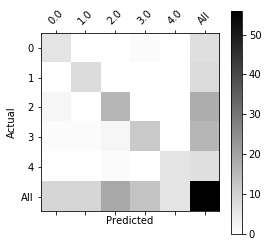

In [64]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '   ' + label_to_emoji(1) + '  ' +  label_to_emoji(2)+ '  ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

이러한 문제를 해결하기 위해 단어 순서를 고려한 정교한 모델을 구축해보자.

## 2 - Emojifier-V2: Using LSTM: 

단어 시퀀스를 고려한 LSTM 모델을 만들어 보자. 이전 모델처럼 pre-train된 워드 임베딩을 사용하지만 이번에는 LSTM에 feed할 것이다. 

In [66]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

Using TensorFlow backend.


### 2.1 - Overview of the model

Emojifier-v2 구조는 다음과 같다.

<img src="
emojifier-v2.png" style="width:700px;height:400px;"> <br>
<caption><center> **Figure 3**: Emojifier-V2. 2-layer LSTM 시퀀스 분류기 </center></caption>



### 2.2 - The Embedding layer

Embedding 레이어를 구현하자. 이 레이어는 input으로 (배치 사이즈, max 인풋 길이) shape의 행렬이다. 이 행렬 값들을 리스트로 변환된 문장들을 대표한다. 즉, 아래 그림과 같이 변환된다.

<img src="embedding1.png" style="width:700px;height:250px;">
<caption><center>
    **Figure 4**: Embedding layer. 이 그림은 두 개의 샘플이 임베딩 레이어를 거쳐가는 것을 보여준다. 둘다 `max_len=5`에 맞게 zero-padding 된 것을 볼 수 있다. 또한, 최종 값의 크기가 (2,max_len,50)인 이유는 사용한 word embedding의 크기가 50이기 때문이다.</center></caption>



In [68]:
def sentences_to_indices(X, word_to_index, max_len):

    m = X.shape[0]                                   # train set 샘플 수
    
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               
        
        # 소문자로 변환 후 단어 단위로 나누기 
        sentence_words =X[i].lower().split()

        j = 0

        for w in sentence_words:
            X_indices[i, j] = word_to_index[w]
            j = j + 1

    return X_indices

In [69]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices = [[ 155345.  225122.       0.       0.       0.]
 [ 220930.  286375.   69714.       0.       0.]
 [ 151204.  192973.  302254.  151349.  394475.]]


pre-train된 단어 벡터를 이용해 Embedding 레이어를 구현하자.

In [70]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    vocab_len = len(word_to_index) + 1                 
    emb_dim = word_to_vec_map["cucumber"].shape[0]     

    emb_matrix = np.zeros((vocab_len, emb_dim))

    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)

    # Build the embedding layer
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [71]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


## 2.3 Building the Emojifier-V2

이제 Emojifier-V2 model을 구축해보자. 모델 구조는 아래 그림과 같다.

<img src="emojifier-v2.png" style="width:700px;height:400px;"> <br>
<caption><center> **Figure 3**: Emojifier-v2. 2-layer LSTM 시퀀스 분류기 </center></caption>

In [73]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):

    sentence_indices = Input(input_shape, dtype='int32')

    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

    embeddings = embedding_layer(sentence_indices)    
    
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)
    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.5)(X)
    X = Dense(5)(X)
    X = Activation('softmax')(X)

    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [74]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
__________

In [75]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

이제 모델을 학습시키자. 

In [76]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

In [77]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
132/132 [==============================] - 0s - loss: 1.6084 - acc: 0.1970     
Epoch 2/50
132/132 [==============================] - 0s - loss: 1.5322 - acc: 0.2955     
Epoch 3/50
132/132 [==============================] - 0s - loss: 1.5008 - acc: 0.3258     
Epoch 4/50
132/132 [==============================] - 0s - loss: 1.4385 - acc: 0.3561     
Epoch 5/50
132/132 [==============================] - 0s - loss: 1.3470 - acc: 0.4545     
Epoch 6/50
132/132 [==============================] - 0s - loss: 1.2334 - acc: 0.5076     
Epoch 7/50
132/132 [==============================] - 0s - loss: 1.1763 - acc: 0.4470     
Epoch 8/50
132/132 [==============================] - 0s - loss: 1.0547 - acc: 0.5758     
Epoch 9/50
132/132 [==============================] - 0s - loss: 0.8771 - acc: 0.7121     
Epoch 10/50
132/132 [==============================] - 0s - loss: 0.8233 - acc: 0.6970     
Epoch 11/50
132/132 [==============================] - 0s - loss: 0.7029 - acc: 0.7500   

Test set으로 모델을 평가해보자.

In [79]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

32/56 [================>.............] - ETA: 0s
Test accuracy =  0.821428562914


약 82%의 정확도를 보였다! 잘못 예측한 것들은 무엇일까? 한번 살펴보자.

In [80]:
# mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:🍴 prediction: any suggestions for dinner	😄
Expected emoji:❤️ prediction: I love taking breaks	😞
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:🍴 prediction: See you at the restaurant	😄
Expected emoji:😞 prediction: go away	⚾
Expected emoji:🍴 prediction: I did not have breakfast ❤️


첫번째 모델에서 'not feeling happy'가 😄로 잘못 예측되었던 것을 봤다. 그렇다면 LSTM을 적용한 모델은 어떨까? 확인해보자.

In [82]:
x_test = np.array(['not feeling happy'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

not feeling happy 😞


이번에는 😞로 맞게 예측한 것을 볼 수 있다.